# Proyecto - Estudio del efecto de la profundidad y conexiones residuales en redes neuronales
### EL4106 Inteligencia Computacional

Profesor de Cátedra: Pablo Estévez<br>
Profesor Auxiliar: Pablo Cornejo<br>

In [ ]:
import torch
import torch.nn as nn
import torch.optim as optim
import torchvision
import torchvision.transforms as transforms
import matplotlib.pyplot as plt
import time
import numpy as np
import seaborn as sns
import pandas as pd
!pip install umap
import umap

  Preparing metadata (setup.py) ... done
  Created wheel for umap: filename=umap-0.1.1-py3-none-any.whl size=3542 sha256=06ab8dda7409b130df1190081dcfd09c32bbabb4240ccd1a68618f17fea75a62
  Stored in directory: /root/.cache/pip/wheels/15/f1/28/53dcf7a309118ed35d810a5f9cb995217800f3f269ab5771cb
Successfully built umap


In [ ]:
from google.colab import drive
drive.mount('/content/drive')


Mounted at /content/drive


## Guardado de datasets

In [ ]:
# Montar Google Drive
drive.mount('/content/drive')

# Semilla fija para garantizar la reproducibilidad
seed = 42
torch.manual_seed(seed)

# Carpeta en Google Drive donde se guardarán los datos
data_path = '/content/drive/My Drive/datasets/cifar10'

# Transformación para el conjunto de entrenamiento con Data Augmentation
def get_train_transform():
    return transforms.Compose([
        transforms.RandomResizedCrop(224, scale=(0.8, 1.0)),  # Recorte aleatorio entre 256 y 480
        transforms.RandomHorizontalFlip(),  # Flip horizontal aleatorio
        transforms.ColorJitter(brightness=0.4, contrast=0.4, saturation=0.4, hue=0.2),  # Jitter de color
        transforms.ToTensor(),
        transforms.Normalize((0.4914, 0.4822, 0.4465), (0.247, 0.243, 0.261)),  # Normalización
    ])

# Transformación para validación y test (sin augmentación)
def get_test_transform():
    return transforms.Compose([
        transforms.Resize(256),
        transforms.CenterCrop(224),
        transforms.ToTensor(),
        transforms.Normalize((0.4914, 0.4822, 0.4465), (0.247, 0.243, 0.261)),  # Normalización
    ])

# Aplicación de las transformaciones
train_transform = get_train_transform()
test_transform = get_test_transform()

# Cargar los datasets con las respectivas transformaciones en Google Drive
train_cifar10 = torchvision.datasets.CIFAR10(
    root=data_path,  # Guardar en Google Drive
    train=True,
    download=True,
    transform=train_transform  # Aplicar las transformaciones de entrenamiento
)

val_cifar10 = torchvision.datasets.CIFAR10(
    root=data_path,  # Guardar en Google Drive
    train=True,
    download=True,
    transform=test_transform  # Validación usa las transformaciones sin augmentación
)

test_cifar10 = torchvision.datasets.CIFAR10(
    root=data_path,  # Guardar en Google Drive
    train=False,
    download=True,
    transform=test_transform  # Test usa las mismas transformaciones que validación
)

# División reproducible del conjunto de datos
train_cifar10, _ = torch.utils.data.random_split(train_cifar10, [45000, 5000], torch.Generator().manual_seed(seed))
_, val_cifar10 = torch.utils.data.random_split(val_cifar10, [45000, 5000], torch.Generator().manual_seed(seed))

# Verificación
print(f"Los datos se guardan en: {data_path}")


Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


100%|██████████| 170498071/170498071 [00:04<00:00, 42137741.06it/s]


Extracting /content/drive/My Drive/datasets/cifar10/cifar-10-python.tar.gz to /content/drive/My Drive/datasets/cifar10
Files already downloaded and verified
Files already downloaded and verified
Los datos se guardan en: /content/drive/My Drive/datasets/cifar10


## Codigo para hacer la carga de datasets del drive

In [ ]:
# Semilla fija para garantizar la reproducibilidad
seed = 42
torch.manual_seed(seed)

# Carpeta en Google Drive donde los datos fueron guardados
data_path = '/content/drive/My Drive/datasets/cifar10'

# Transformación para el conjunto de entrenamiento con Data Augmentation
def get_train_transform():
    return transforms.Compose([
        transforms.RandomResizedCrop(224, scale=(0.8, 1.0)),  # Recorte aleatorio entre 256 y 480
        transforms.RandomHorizontalFlip(),  # Flip horizontal aleatorio
        transforms.ColorJitter(brightness=0.4, contrast=0.4, saturation=0.4, hue=0.2),  # Jitter de color
        transforms.ToTensor(),
        transforms.Normalize((0.4914, 0.4822, 0.4465), (0.247, 0.243, 0.261)),  # Normalización
    ])

# Transformación para validación y test (sin augmentación)
def get_test_transform():
    return transforms.Compose([
        transforms.Resize(256),
        transforms.CenterCrop(224),
        transforms.ToTensor(),
        transforms.Normalize((0.4914, 0.4822, 0.4465), (0.247, 0.243, 0.261)),  # Normalización
    ])

# Aplicar las transformaciones pero sin descargar de nuevo los datos
train_transform = get_train_transform()
test_transform = get_test_transform()

# Cargar los datasets desde Google Drive SIN volver a descargar
train_cifar10 = torchvision.datasets.CIFAR10(
    root=data_path,  # Ruta donde los datos ya están guardados
    train=True,
    download=False,  # No volver a descargar, ya están en el drive
    transform=train_transform  # Aplicar las transformaciones de entrenamiento
)

val_cifar10 = torchvision.datasets.CIFAR10(
    root=data_path,
    train=True,
    download=False,  # No volver a descargar
    transform=test_transform  # Validación sin augmentación
)

test_cifar10 = torchvision.datasets.CIFAR10(
    root=data_path,
    train=False,
    download=False,  # No volver a descargar
    transform=test_transform  # Test sin augmentación
)

# División reproducible del conjunto de datos
train_cifar10, _ = torch.utils.data.random_split(train_cifar10, [45000, 5000], torch.Generator().manual_seed(seed))
_, val_cifar10 = torch.utils.data.random_split(val_cifar10, [45000, 5000], torch.Generator().manual_seed(seed))

# Verificación
print(f"Datos cargados desde: {data_path}")


Datos cargados desde: /content/drive/My Drive/datasets/cifar10


### Tema: Regularización
La **regularización** es un conjunto de técnicas utilizadas en machine learning y deep learning para prevenir el **sobreajuste** (overfitting). El sobreajuste ocurre cuando un modelo aprende demasiado bien los detalles y ruido de los datos de entrenamiento, lo que resulta en un mal rendimiento cuando se evalúa en nuevos datos no vistos (conjunto de validación o test). La regularización ayuda a mejorar la **capacidad de generalización** del modelo, es decir, su capacidad para funcionar bien en datos no vistos.

### Tipos comunes de regularización:

1. **L2 Regularization (Weight Decay)**:
   - **Descripción**: Penaliza los pesos grandes al agregar un término a la función de pérdida que aumenta con el tamaño de los pesos.
   - **Fórmula**: El término de penalización en la función de pérdida es:
$ L(\theta) = L_0 + \lambda \sum_{i=1}^{n} \theta_i^2 $
     Donde:
     - $ L_0 $ es la pérdida original (por ejemplo, la entropía cruzada).
     - $ \theta_i $ son los pesos de la red.
     - $ \lambda $ es el hiperparámetro que controla la magnitud de la penalización (también llamado **weight decay**).
   - **Efecto**: Evita que los pesos crezcan demasiado, lo que podría hacer que el modelo sea demasiado dependiente de características particulares de los datos de entrenamiento.

2. **L1 Regularization**:
   - **Descripción**: Similar a L2, pero en lugar de penalizar los pesos grandes con un término cuadrático, penaliza la suma de los valores absolutos de los pesos.
   - **Fórmula**:
     $$
  L(\theta) = L_0 + \lambda \sum_{i=1}^{n} |\theta_i|
     $$
   - **Efecto**: Alienta la **sparsity** (la mayoría de los pesos se vuelven cero), lo que puede resultar en modelos más simples.

3. **Dropout**:
   - **Descripción**: Durante el entrenamiento, **desactiva aleatoriamente** una fracción de las neuronas en cada capa en cada paso de entrenamiento. Esto evita que el modelo se vuelva demasiado dependiente de cualquier neurona individual.
   - **Efecto**: Dropout actúa como un ensamble implícito de varias redes neuronales, entrenando diferentes subredes.

4. **Early Stopping**:
   - **Descripción**: Se detiene el entrenamiento del modelo cuando la precisión en el conjunto de validación deja de mejorar después de un cierto número de épocas.
   - **Efecto**: Evita que el modelo continúe ajustándose demasiado a los datos de entrenamiento.

5. **Data Augmentation**:
   - **Descripción**: **Aumentar artificialmente** el conjunto de datos al aplicar transformaciones aleatorias (rotaciones, escalado, recortes, etc.) puede hacer que el modelo vea más variedad en los datos y evitar el sobreajuste.
   - **Efecto**: Hace que el modelo aprenda características más generales y robustas.

6. **Batch Normalization**:
   - **Descripción**: Normaliza las activaciones de cada capa durante el entrenamiento, asegurando que la distribución de las activaciones permanezca estable. También tiene un efecto regularizador.
   - **Efecto**: Ayuda a estabilizar y acelerar el entrenamiento, además de reducir el sobreajuste.

### Aspectos a considerar al aplicar regularización:

1. **Hiperparámetros**:
   - El valor del coeficiente de regularización $\lambda$ en L2/L1 es crucial. Si es muy bajo, no se sentirá el efecto de la regularización, y si es muy alto, puede hacer que el modelo sea demasiado conservador.
   - Para **dropout**, la probabilidad de "dropout" $p$ debe seleccionarse cuidadosamente (valores comunes entre **0.3 y 0.5**).

2. **Balance entre regularización y ajuste**:
   - La regularización busca reducir el sobreajuste, pero demasiada regularización puede causar subajuste. Es importante encontrar un equilibrio.

3. **Evaluación con conjunto de validación**:
   - Siempre evalúa el impacto de la regularización en un conjunto de validación. Si la precisión de entrenamiento es alta pero la de validación es baja, probablemente estés sobreajustando.

4. **Tamaño del modelo y datos**:
   - Modelos grandes entrenados en conjuntos de datos pequeños son más propensos al sobreajuste, por lo que necesitan más regularización.

### Ejemplo práctico:

Si estás entrenando una red neuronal profunda en CIFAR-10 y notas que el modelo tiene una alta precisión en el conjunto de entrenamiento pero baja en validación, es posible que esté ocurriendo sobreajuste. Podrías intentar:
- Agregar **L2 regularization** al optimizador ajustando el parámetro `weight_decay` (por ejemplo, **1e-4**).
- Usar **dropout** con $p = 0.5$ en las capas completamente conectadas.
- Aumentar el tamaño del conjunto de datos mediante **data augmentation** aplicando rotaciones, traslaciones o recortes aleatorios.

##Red plana sin regularizacion en pytorch

In [ ]:
# Define CNN Model (Flat architecture)
class FlatCNN(nn.Module):
    def __init__(self):
        super(FlatCNN, self).__init__()
        # 3 input channels (RGB), 32 filters of size 3x3, padding=1 to keep the same size
        self.conv1 = nn.Conv2d(3, 32, kernel_size=3, padding=1)
        self.conv2 = nn.Conv2d(32, 64, kernel_size=3, padding=1)
        self.conv3 = nn.Conv2d(64, 128, kernel_size=3, padding=1)
        self.fc1 = nn.Linear(128 * 4 * 4, 256)  # Fully connected layer
        self.fc2 = nn.Linear(256, 10)  # 10 classes (CIFAR-10)
        self.pool = nn.MaxPool2d(2, 2)  # Max pooling layer

    def forward(self, x):
        # Apply conv -> relu -> pool
        x = self.pool(torch.relu(self.conv1(x)))
        x = self.pool(torch.relu(self.conv2(x)))
        x = self.pool(torch.relu(self.conv3(x)))

        # Flatten the output for the fully connected layers
        x = x.view(-1, 128 * 4 * 4)
        x = torch.relu(self.fc1(x))
        x = self.fc2(x)
        return x


### Función de entrenamiento y visualización

In [ ]:
def show_curves(curves):
    fig, ax = plt.subplots(1, 2, figsize=(13, 5))
    fig.set_facecolor('white')

    epochs = np.arange(len(curves["val_loss"])) + 1

    ax[0].plot(epochs, curves['val_loss'], label='validation')
    ax[0].plot(epochs, curves['train_loss'], label='training')
    ax[0].set_xlabel('Epoch')
    ax[0].set_ylabel('Loss')
    ax[0].set_title('Loss evolution during training')
    ax[0].legend()

    ax[1].plot(epochs, curves['val_acc'], label='validation')
    ax[1].plot(epochs, curves['train_acc'], label='training')
    ax[1].set_xlabel('Epoch')
    ax[1].set_ylabel('Accuracy')
    ax[1].set_title('Accuracy evolution during training')
    ax[1].legend()

    plt.show()

In [ ]:
def train_step(x_batch, y_batch, model, optimizer, criterion, use_gpu):
    # Predicción
    y_predicted = model(x_batch)

    # Cálculo de loss
    loss = criterion(y_predicted, y_batch)

    # Actualización de parámetros
    optimizer.zero_grad()
    loss.backward()
    optimizer.step()

    return y_predicted, loss


def evaluate(val_loader, model, criterion, use_gpu):
    cumulative_loss = 0
    cumulative_predictions = 0
    data_count = 0

    for x_val, y_val in val_loader:
        if use_gpu:
            x_val = x_val.cuda()
            y_val = y_val.cuda()

        y_predicted = model(x_val)

        loss = criterion(y_predicted, y_val)

        class_prediction = torch.argmax(y_predicted, axis=1).long()

        cumulative_predictions += (y_val == class_prediction).sum().item()
        cumulative_loss += loss.item()
        data_count += y_val.shape[0]

    val_acc = cumulative_predictions / data_count
    val_loss = cumulative_loss / len(val_loader)

    return val_acc, val_loss


def train_model(
    model,
    train_dataset,
    val_dataset,
    epochs,
    criterion,
    batch_size,
    lr,
    n_evaluations_per_epoch=6,
    use_gpu=True,
    data_augmentation=True,
):
    original_transform = torchvision.transforms.Compose([
        torchvision.transforms.ToTensor(),
        torchvision.transforms.Normalize((0.4914, 0.4822, 0.4465), (0.247, 0.243, 0.261)),
    ])

    if data_augmentation:
        train_dataset.dataset.transform = torchvision.transforms.Compose([
            original_transform,
            torchvision.transforms.RandomHorizontalFlip(),
            torchvision.transforms.Lambda(lambda x: x + torch.randn(3, 1, 1) * 0.05)
        ])

    else:
        train_dataset.dataset.transform = original_transform

    print(f"Using train transform: {train_dataset.dataset.transform}")
    print(f"Using validation transform: {val_dataset.dataset.transform}")

    if use_gpu:
        model.cuda()

    # Definición de dataloader
    train_loader = torch.utils.data.DataLoader(train_dataset, batch_size=batch_size, shuffle=True, num_workers=2, pin_memory=use_gpu)
    val_loader = torch.utils.data.DataLoader(val_dataset, batch_size=len(val_dataset), shuffle=False, pin_memory=use_gpu)

    # Optimizer: SGD with momentum
    optimizer = torch.optim.SGD(model.parameters(), lr=lr, momentum=0.9, weight_decay=0.0001)

    # Definir el scheduler para reducir el learning rate
    scheduler = torch.optim.lr_scheduler.StepLR(optimizer, step_size=30, gamma=0.1)

    # Listas para guardar curvas de entrenamiento
    curves = {
        "train_acc": [],
        "val_acc": [],
        "train_loss": [],
        "val_loss": [],
    }

    t0 = time.perf_counter()

    iteration = 0

    n_batches = len(train_loader)

    for epoch in range(epochs):
        print(f"\rEpoch {epoch + 1}/{epochs}")
        cumulative_train_loss = 0
        cumulative_train_corrects = 0
        train_loss_count = 0
        train_acc_count = 0

        # Entrenamiento del modelo
        model.train()
        for i, (x_batch, y_batch) in enumerate(train_loader):
            if use_gpu:
                x_batch = x_batch.cuda()
                y_batch = y_batch.cuda()

            y_predicted, loss = train_step(x_batch, y_batch, model, optimizer, criterion, use_gpu)

            cumulative_train_loss += loss.item()
            train_loss_count += 1
            train_acc_count += y_batch.shape[0]

            # Calculamos número de aciertos
            class_prediction = torch.argmax(y_predicted, axis=1).long()
            cumulative_train_corrects += (y_batch == class_prediction).sum().item()

            if (i % (n_batches // n_evaluations_per_epoch) == 0) and (i > 0):
                train_loss = cumulative_train_loss / train_loss_count
                train_acc = cumulative_train_corrects / train_acc_count

                print(f"Iteration {iteration} - Batch {i}/{len(train_loader)} - Train loss: {train_loss}, Train acc: {train_acc}")

            iteration += 1

        model.eval()
        with torch.no_grad():
            val_acc, val_loss = evaluate(val_loader, model, criterion, use_gpu)

        print(f"Val loss: {val_loss}, Val acc: {val_acc}")

        train_loss = cumulative_train_loss / train_loss_count
        train_acc = cumulative_train_corrects / train_acc_count

        curves["train_acc"].append(train_acc)
        curves["val_acc"].append(val_acc)
        curves["train_loss"].append(train_loss)
        curves["val_loss"].append(val_loss)

        # Step del scheduler al final de cada época
        scheduler.step()

    print()
    print(f"Tiempo total de entrenamiento: {time.perf_counter() - t0:.4f} [s]")

    model.cpu()

    if data_augmentation:
        train_dataset.dataset.transform = original_transform

    return curves

### Bloque de entrenamiento principal

In [ ]:
# Training parameters
model = FlatCNN()
criterion = nn.CrossEntropyLoss()
batch_size =  256
epochs = 30
lr = 0.001
use_gpu = torch.cuda.is_available()

# Train the model using SGD
curves = train_model(
    model=model,
    train_dataset=train_cifar10,
    val_dataset=val_cifar10,
    epochs=epochs,
    criterion=criterion,
    batch_size=batch_size,
    lr=lr,
    n_evaluations_per_epoch=6,
    use_gpu=True,
    data_augmentation=True,
)
show_curves(curves)

Using train transform: Compose(
    Compose(
    ToTensor()
    Normalize(mean=(0.4914, 0.4822, 0.4465), std=(0.247, 0.243, 0.261))
)
    RandomHorizontalFlip(p=0.5)
    Lambda()
)
Using validation transform: Compose(
    ToTensor()
    Normalize(mean=(0.4914, 0.4822, 0.4465), std=(0.247, 0.243, 0.261))
)


NameError: name 'weight_decay' is not defined

## Red plana con regularizacion en pytorch

In [ ]:
# Define CNN Model (Flat architecture) with Regularization
class FlatCNN(nn.Module):
    def __init__(self):
        super(FlatCNN, self).__init__()
        self.conv1 = nn.Conv2d(3, 32, kernel_size=3, padding=1)
        self.conv2 = nn.Conv2d(32, 64, kernel_size=3, padding=1)
        self.conv3 = nn.Conv2d(64, 128, kernel_size=3, padding=1)
        self.dropout = nn.Dropout(p=0.5)
        self.fc1 = nn.Linear(128 * 4 * 4, 256)
        self.fc2 = nn.Linear(256, 10)
        self.pool = nn.MaxPool2d(2, 2)

    def forward(self, x):
        x = self.pool(torch.relu(self.conv1(x)))
        x = self.pool(torch.relu(self.conv2(x)))
        x = self.pool(torch.relu(self.conv3(x)))
        x = x.view(-1, 128 * 4 * 4)
        x = torch.relu(self.fc1(x))
        x = self.dropout(x)
        x = self.fc2(x)
        return x

### Función de entrenamiento y visualización

In [ ]:
# Function to extract feature maps using hooks
def extract_feature_maps(model, layers, input_data):
    feature_maps = []

    def hook(module, input, output):
        feature_maps.append(output.detach().cpu().numpy())  # Extraer los feature maps

    hooks = []
    for layer in layers:
        hooks.append(layer.register_forward_hook(hook))  # Registrar hooks

    # Forward pass
    _ = model(input_data.cuda())  # Asumimos que usamos GPU

    # Eliminar hooks
    for hook in hooks:
        hook.remove()

    return feature_maps

# Function to plot feature maps with UMAP
def plot_feature_maps_with_umap(feature_maps, layer_names):
    reducer = umap.UMAP()

    for idx, fmap in enumerate(feature_maps):
        # Flatten the feature maps (from [batch, channels, height, width] to [batch, channels*height*width])
        fmap_flattened = fmap.reshape(fmap.shape[0], -1)

        # Apply UMAP to reduce to 2D
        umap_embedding = reducer.fit_transform(fmap_flattened)

        # Visualize with scatter plot
        plt.figure(figsize=(8, 6))
        plt.scatter(umap_embedding[:, 0], umap_embedding[:, 1], cmap='Spectral', s=5)
        plt.title(f'UMAP projection of feature maps from {layer_names[idx]}')
        plt.show()

# Function to show gradient histograms
def show_gradients(model):
    for name, param in model.named_parameters():
        if param.requires_grad and param.grad is not None:
            plt.hist(param.grad.cpu().numpy().flatten(), bins=50)
            plt.title(f'Gradients for {name}')
            plt.show()

# Function to train the model
def train_model(model, train_dataset,
    val_dataset, epochs, criterion, batch_size, lr,
    n_evaluations_per_epoch=6,
    use_gpu=True,
    data_augmentation=True,
):
    original_transform = torchvision.transforms.Compose([
        torchvision.transforms.ToTensor(),
        torchvision.transforms.Normalize((0.4914, 0.4822, 0.4465), (0.247, 0.243, 0.261)),
    ])

    if data_augmentation:
        train_dataset.dataset.transform = torchvision.transforms.Compose([
            original_transform,
            torchvision.transforms.RandomHorizontalFlip(),
            torchvision.transforms.Lambda(lambda x: x + torch.randn(3, 1, 1) * 0.05)
        ])

    else:
        train_dataset.dataset.transform = original_transform

    print(f"Using train transform: {train_dataset.dataset.transform}")
    print(f"Using validation transform: {val_dataset.dataset.transform}")

    if use_gpu:
        model.cuda()

    # Definición de dataloader
    train_loader = torch.utils.data.DataLoader(train_dataset, batch_size=batch_size, shuffle=True, num_workers=2, pin_memory=use_gpu)
    val_loader = torch.utils.data.DataLoader(val_dataset, batch_size=len(val_dataset), shuffle=False, pin_memory=use_gpu)


    optimizer = optim.SGD(model.parameters(), lr=lr, momentum=0.9, weight_decay=1e-4)  # L2 Regularization (weight_decay)

    curves = {"train_acc": [], "val_acc": [], "train_loss": [], "val_loss": []}

    t0 = time.perf_counter()

    iteration = 0

    n_batches = len(train_loader)

    for epoch in range(epochs):
        print(f"\rEpoch {epoch + 1}/{epochs}")
        model.train()
        cumulative_train_loss = 0
        cumulative_train_corrects = 0
        train_loss_count = 0
        train_acc_count = 0

        for i, (x_batch, y_batch) in enumerate(train_loader):
            if use_gpu:
                x_batch = x_batch.cuda()  # Mover los datos a la GPU
                y_batch = y_batch.cuda()

            y_predicted, loss = train_step(x_batch, y_batch, model, optimizer, criterion, use_gpu)
            cumulative_train_loss += loss.item()
            train_loss_count += 1
            train_acc_count += y_batch.shape[0]

            class_prediction = torch.argmax(y_predicted, axis=1).long()
            cumulative_train_corrects += (y_batch == class_prediction).sum().item()

            # Calculamos número de aciertos
            class_prediction = torch.argmax(y_predicted, axis=1).long()
            cumulative_train_corrects += (y_batch == class_prediction).sum().item()

            if (i % (n_batches // n_evaluations_per_epoch) == 0) and (i > 0):
                train_loss = cumulative_train_loss / train_loss_count
                train_acc = cumulative_train_corrects / train_acc_count

                print(f"Iteration {iteration} - Batch {i}/{len(train_loader)} - Train loss: {train_loss}, Train acc: {train_acc}")

            iteration += 1

        model.eval()
        with torch.no_grad():
            val_acc, val_loss = evaluate(val_loader, model, criterion, use_gpu)

        print(f"Val loss: {val_loss}, Val acc: {val_acc}")

        train_loss = cumulative_train_loss / train_loss_count
        train_acc = cumulative_train_corrects / train_acc_count

        curves["train_acc"].append(train_acc)
        curves["val_acc"].append(val_acc)
        curves["train_loss"].append(train_loss)
        curves["val_loss"].append(val_loss)

    print()
    print(f"Tiempo total de entrenamiento: {time.perf_counter() - t0:.4f} [s]")

    model.cpu()

    if data_augmentation:
        train_dataset.dataset.transform = original_transform

    return curves

# Training step function
def train_step(x_batch, y_batch, model, optimizer, criterion, use_gpu):
    y_predicted = model(x_batch)  # Hacer forward pass
    loss = criterion(y_predicted, y_batch)  # Calcular la pérdida
    optimizer.zero_grad()  # Poner a cero los gradientes
    loss.backward()  # Hacer backward pass para calcular los gradientes
    optimizer.step()  # Actualizar los parámetros del modelo
    return y_predicted, loss

# Evaluation function
def evaluate(val_loader, model, criterion, use_gpu):
    cumulative_loss = 0
    cumulative_predictions = 0
    data_count = 0

    for x_val, y_val in val_loader:
        if use_gpu:
            x_val = x_val.cuda()
            y_val = y_val.cuda()

        y_predicted = model(x_val)
        loss = criterion(y_predicted, y_val)

        class_prediction = torch.argmax(y_predicted, axis=1).long()
        cumulative_predictions += (y_val == class_prediction).sum().item()
        cumulative_loss += loss.item()
        data_count += y_val.shape[0]

    val_acc = cumulative_predictions / data_count
    val_loss = cumulative_loss / len(val_loader)
    return val_acc, val_loss

# Function to show training and validation curves
def show_curves(curves):
    fig, ax = plt.subplots(1, 2, figsize=(13, 5))
    fig.set_facecolor('white')

    epochs = np.arange(len(curves["val_loss"])) + 1

    ax[0].plot(epochs, curves['val_loss'], label='validation')
    ax[0].plot(epochs, curves['train_loss'], label='training')
    ax[0].set_xlabel('Epoch')
    ax[0].set_ylabel('Loss')
    ax[0].set_title('Loss evolution during training')
    ax[0].legend()

    ax[1].plot(epochs, curves['val_acc'], label='validation')
    ax[1].plot(epochs, curves['train_acc'], label='training')
    ax[1].set_xlabel('Epoch')
    ax[1].set_ylabel('Accuracy')
    ax[1].set_title('Accuracy evolution during training')
    ax[1].legend()

    plt.show()


### Bloque de entrenamiento principal

Using train transform: Compose(
    Compose(
    ToTensor()
    Normalize(mean=(0.4914, 0.4822, 0.4465), std=(0.247, 0.243, 0.261))
)
    RandomHorizontalFlip(p=0.5)
    Lambda()
)
Using validation transform: Compose(
    ToTensor()
    Normalize(mean=(0.4914, 0.4822, 0.4465), std=(0.247, 0.243, 0.261))
)
Epoch 1/30
Iteration 117 - Batch 117/704 - Train loss: 2.2958499274011386, Train acc: 0.2579449152542373
Iteration 234 - Batch 234/704 - Train loss: 2.284976756319087, Train acc: 0.2949468085106383
Iteration 351 - Batch 351/704 - Train loss: 2.2606420916589824, Train acc: 0.33824573863636365
Iteration 468 - Batch 468/704 - Train loss: 2.2258633982652287, Train acc: 0.3734674840085288
Iteration 585 - Batch 585/704 - Train loss: 2.1948481708663317, Train acc: 0.40017064846416384
Iteration 702 - Batch 702/704 - Train loss: 2.163497202596488, Train acc: 0.42411984352773824
Val loss: 1.9497456550598145, Val acc: 0.301
Epoch 2/30
Iteration 821 - Batch 117/704 - Train loss: 1.931087583808575

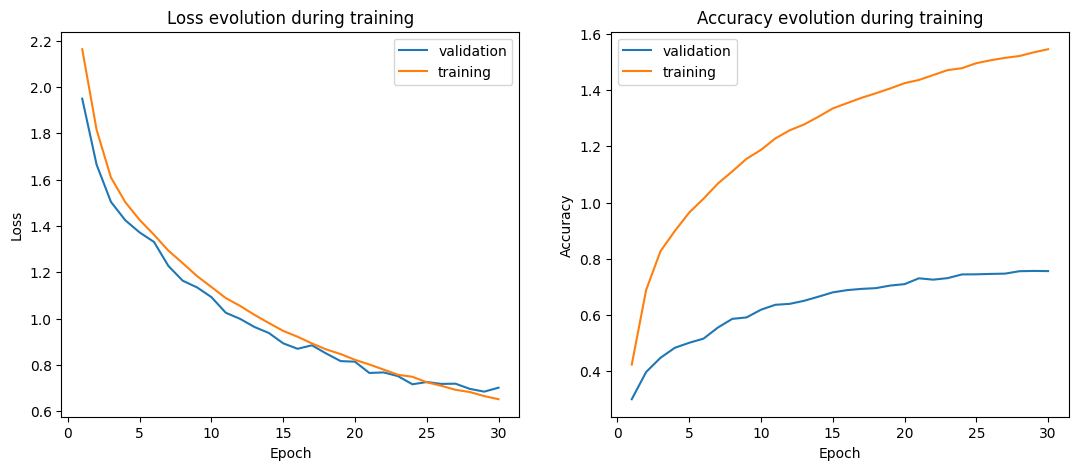

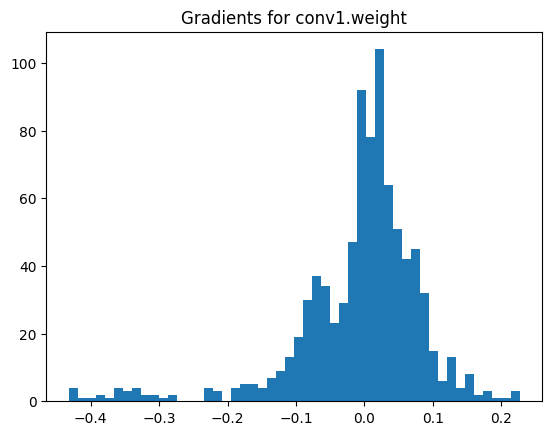

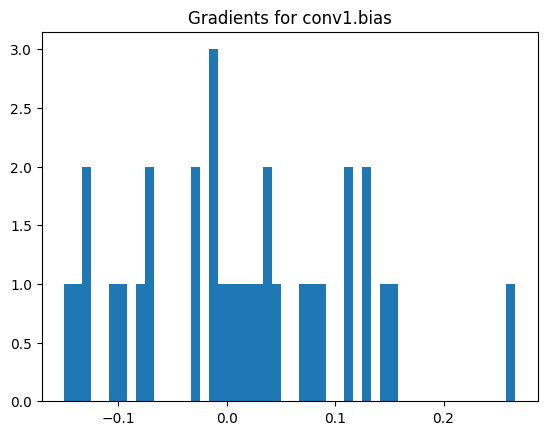

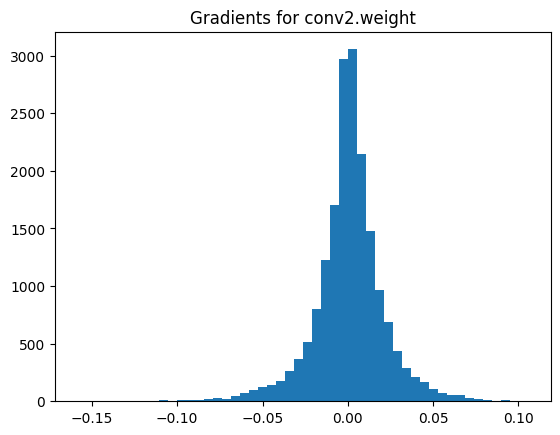

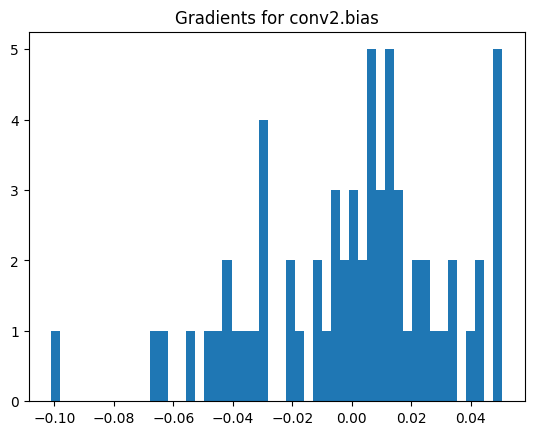

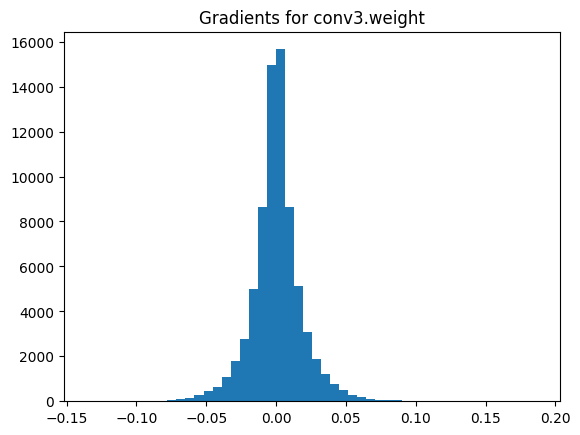

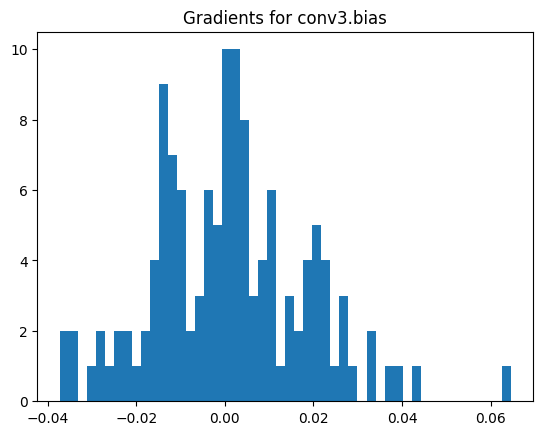

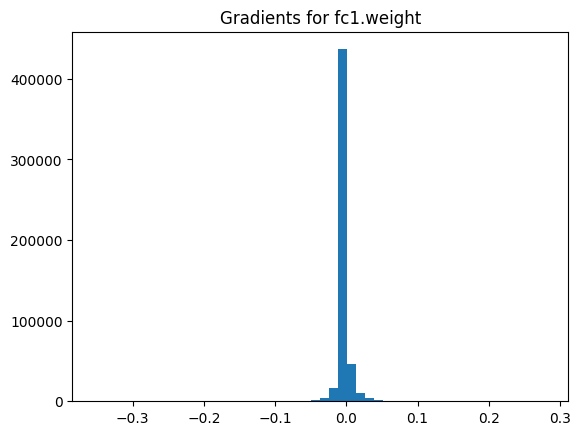

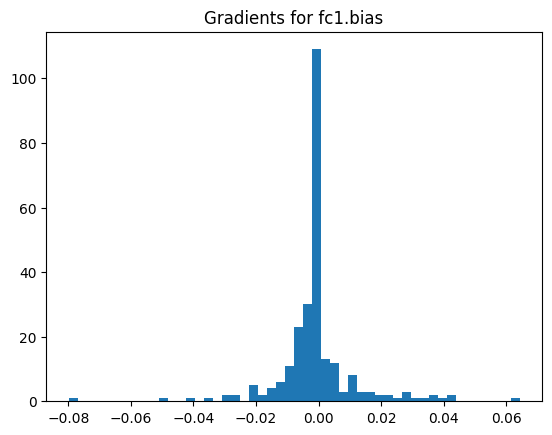

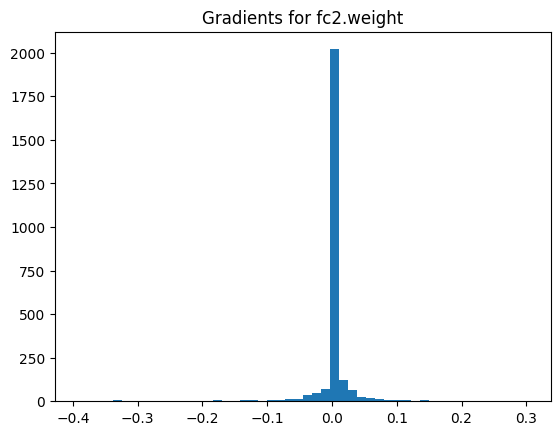

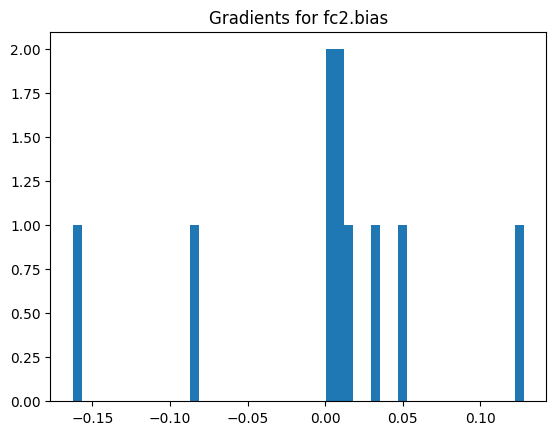

In [ ]:
# Main training parameters
model = FlatCNN()
criterion = nn.CrossEntropyLoss()
batch_size = 64
epochs = 30
lr = 0.001

# Train the model
curves = train_model(
    model,
    train_cifar10,
    val_cifar10,
    epochs,
    criterion,
    batch_size,
    lr,
)

# Visualize training curves
show_curves(curves)


# Show gradients as histograms
show_gradients(model)

In [ ]:
# Visualize training curves
show_curves(curves)

# Show feature maps using UMAP
# Assuming `features` is the feature map extracted from the model
plot_feature_maps(features)

# Show gradients as histograms
show_gradients(model)